In [1]:
from pathlib import Path
import torch
import numpy as np
import zuko
import dill
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "Times New Roman"

rng_seed = 1
# pyro.set_rng_seed(int(rng_seed))
torch.manual_seed(int(rng_seed))
np.random.seed(int(rng_seed))

Text(0, 0.5, 'posterior samples')

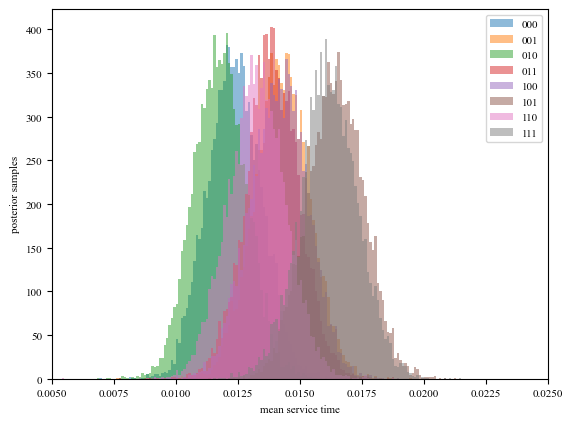

In [13]:
dir_path = Path.cwd()

# /bayes-air-atrds-attempt-8/checkpoints/nsf_730
ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_730/final/output_dict.pkl'

with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

guide = output_dict['guide']

# guide = zuko.flows.NSF(
#     features=1,
#     context=5,
#     hidden_features=(16, 16),
#     bins=4,
# ) #this is the only one that really works??


labels = []
names = []

for y in range(2):
    for x in range(2):
        for w in range(2):
            label = torch.zeros(5, dtype=torch.float)
            label[2*y+x] = 1.0
            label[4] = w
            labels.append(label)
            names.append(f'{y}{x}{w}')

def transform_sample(sample):
    return .004 * sample + .02

n_samples = 10000

fig, ax = plt.subplots()
# for label, color in zip(labels, ['b', 'r']):
bins = np.arange(.0050, .0351, .0001)
for label, name in zip(labels, names):
    # print(label)
    samples = transform_sample(guide(label).sample((n_samples,)))
    ax.hist(
        samples, 
        alpha=.5, 
        fill=True, 
        edgecolor='k', 
        bins=bins,
        linewidth=0,
        label=f'{name}',
    )
    
ax.set_xlim(0.005,.025)
ax.legend()
ax.set_xlabel("mean service time")
ax.set_ylabel("posterior samples")


In [14]:
q_samples = {}

for label, name in zip(labels, names):
    q_samples[name] = transform_sample(guide(label).sample((n_samples,))).squeeze().detach().cpu().numpy()

print(q_samples)

{'000': array([0.01207543, 0.01257823, 0.01172598, ..., 0.0119629 , 0.01223374,
       0.01211923], dtype=float32), '001': array([0.01336897, 0.01279993, 0.0140156 , ..., 0.01506922, 0.01494271,
       0.0135065 ], dtype=float32), '010': array([0.01062108, 0.01210802, 0.01239659, ..., 0.0133881 , 0.01315214,
       0.01078067], dtype=float32), '011': array([0.01384325, 0.01273458, 0.01577235, ..., 0.01504227, 0.01371804,
       0.01496833], dtype=float32), '100': array([0.01248336, 0.01400879, 0.01291086, ..., 0.0137778 , 0.01597044,
       0.01600948], dtype=float32), '101': array([0.01747221, 0.01740098, 0.01614279, ..., 0.01659227, 0.01547198,
       0.01712995], dtype=float32), '110': array([0.01376418, 0.01261455, 0.01330864, ..., 0.01424214, 0.01280299,
       0.01380611], dtype=float32), '111': array([0.01501451, 0.01745325, 0.01834171, ..., 0.01743217, 0.01721257,
       0.01597191], dtype=float32)}


000 posterior, mean=0.01234, std=0.00110
001 posterior, mean=0.01429, std=0.00111
010 posterior, mean=0.01178, std=0.00104
011 posterior, mean=0.01389, std=0.00109
100 posterior, mean=0.01411, std=0.00116
101 posterior, mean=0.01643, std=0.00116
110 posterior, mean=0.01329, std=0.00117
111 posterior, mean=0.01617, std=0.00115


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


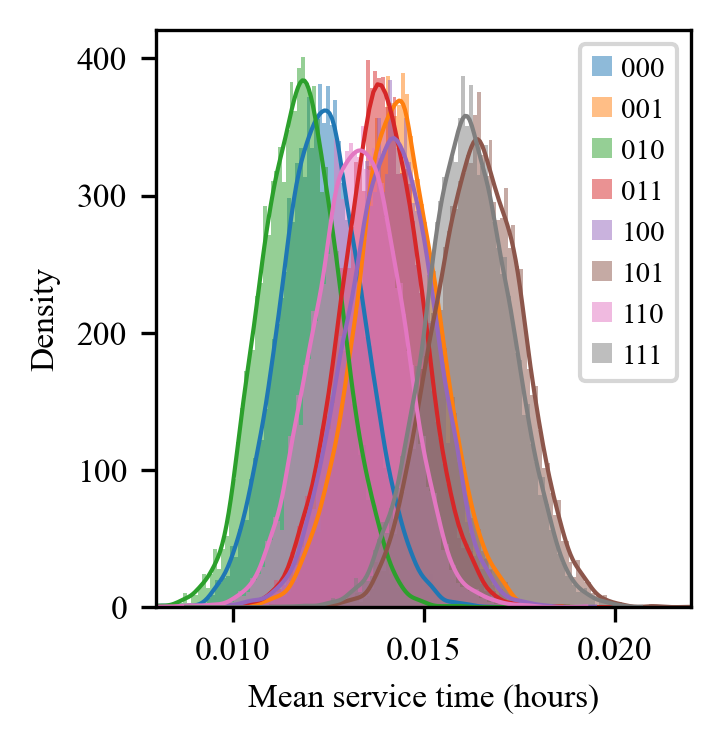

In [103]:
def plot_from_labels_names(samples, labels, names, title=None, figsize=(3.5,3.5)):

    plotting_df = {}

    fig, ax = plt.subplots(figsize=figsize, dpi=300)

    # groups = samples.keys()
    groups = names

    for group in groups:
        plotting_df[group] = pd.DataFrame(
            {
                "Mean service time (hours)": samples[group],
                "group": group,
            },
        ) 

    for group in groups:
        
        sns.histplot(
            x="Mean service time (hours)",
            data=plotting_df[group],
            ax=ax,
            binwidth=.0001,
            stat="density",
            # shrink=0.8,
            # hue="group",
            # palette=palette,
            edgecolor='none',
            # label=r"$\mathdefault{g_\gamma}\to$" + f"{''.join(list(group))}",
            label=f"{''.join(list(group))}",
            kde=True,
            line_kws=dict(linewidth=1)
        )
        print(f"{group} posterior, mean={samples[group].mean():.5f}, std={samples[group].std():.5f}"),


    ax.set_xlim(.008, .022)
    # ax.set_title("mean service time posteriors" if title is None else title)
    ax.legend(
        # title='Posterior', 
        fontsize=7,
        handlelength=.7,
        handletextpad=.3,
    )

    return fig

fig = plot_from_labels_names(q_samples, labels, names, figsize=(2.3,2.5))
for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/q_phi_nsf_730_all.{ext}', bbox_inches='tight', pad_inches=0)


In [19]:
def label_name_from_yxw(y, x, w):
    label = torch.zeros(5, dtype=torch.float)
    label[2*y+x] = 1.0
    label[4] = w
    name = f'{y}{x}{w}'
    return label, name

def generate_label_name_pairs(on):
    label_pairs = []
    name_pairs = []
    for a in range(2):
        for b in range(2):
            if on == 'y':
                l0, n0 = label_name_from_yxw(0, a, b)
                l1, n1 = label_name_from_yxw(1, a, b)
            elif on == 'x':
                l0, n0 = label_name_from_yxw(a, 0, b)
                l1, n1 = label_name_from_yxw(a, 1, b)
            elif on == 'w':
                l0, n0 = label_name_from_yxw(a, b, 0)
                l1, n1 = label_name_from_yxw(a, b, 1)
            label_pairs.append([l0, l1])
            name_pairs.append([n0, n1])
    return {
        'label_pairs': label_pairs,
        'name_pairs': name_pairs
    }

lnp = {
    on: generate_label_name_pairs(on)
    for on in ('y', 'x', 'w')
}

print(lnp)

def plot_from_labels_names_lnp_entry(samples, on, idx, title=None):
    return plot_from_labels_names(
        q_samples,
        lnp[on]["label_pairs"][idx], 
        lnp[on]["name_pairs"][idx],
        title,
    )

{'y': {'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([0., 0., 1., 0., 0.])], [tensor([1., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 1.])], [tensor([0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0.])], [tensor([0., 1., 0., 0., 1.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '100'], ['001', '101'], ['010', '110'], ['011', '111']]}, 'x': {'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([0., 1., 0., 0., 0.])], [tensor([1., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 1.])], [tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0.])], [tensor([0., 0., 1., 0., 1.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '010'], ['001', '011'], ['100', '110'], ['101', '111']]}, 'w': {'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([1., 0., 0., 0., 1.])], [tensor([0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 1.])], [tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 1.])], [tensor([0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '

000 posterior, mean=0.01234, std=0.00110
100 posterior, mean=0.01411, std=0.00116


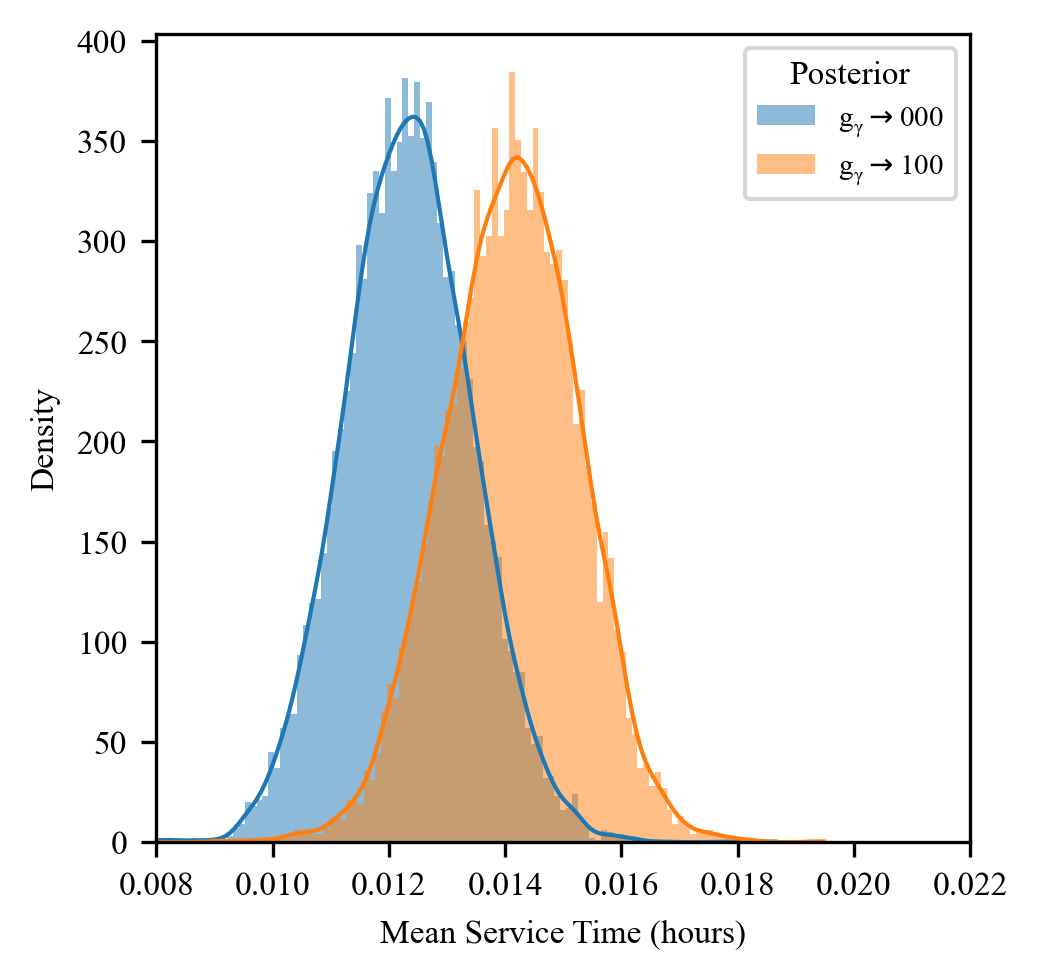

001 posterior, mean=0.01429, std=0.00111
101 posterior, mean=0.01643, std=0.00116


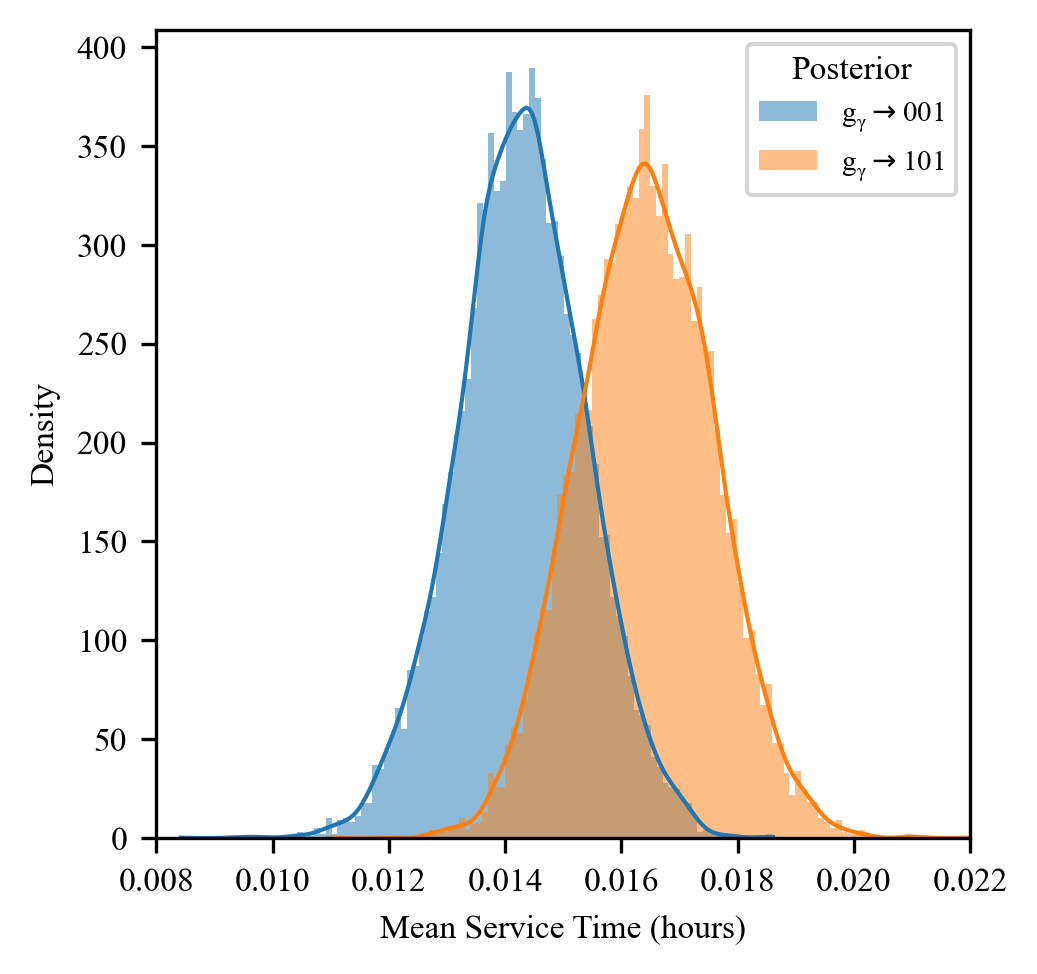

010 posterior, mean=0.01178, std=0.00104
110 posterior, mean=0.01329, std=0.00117


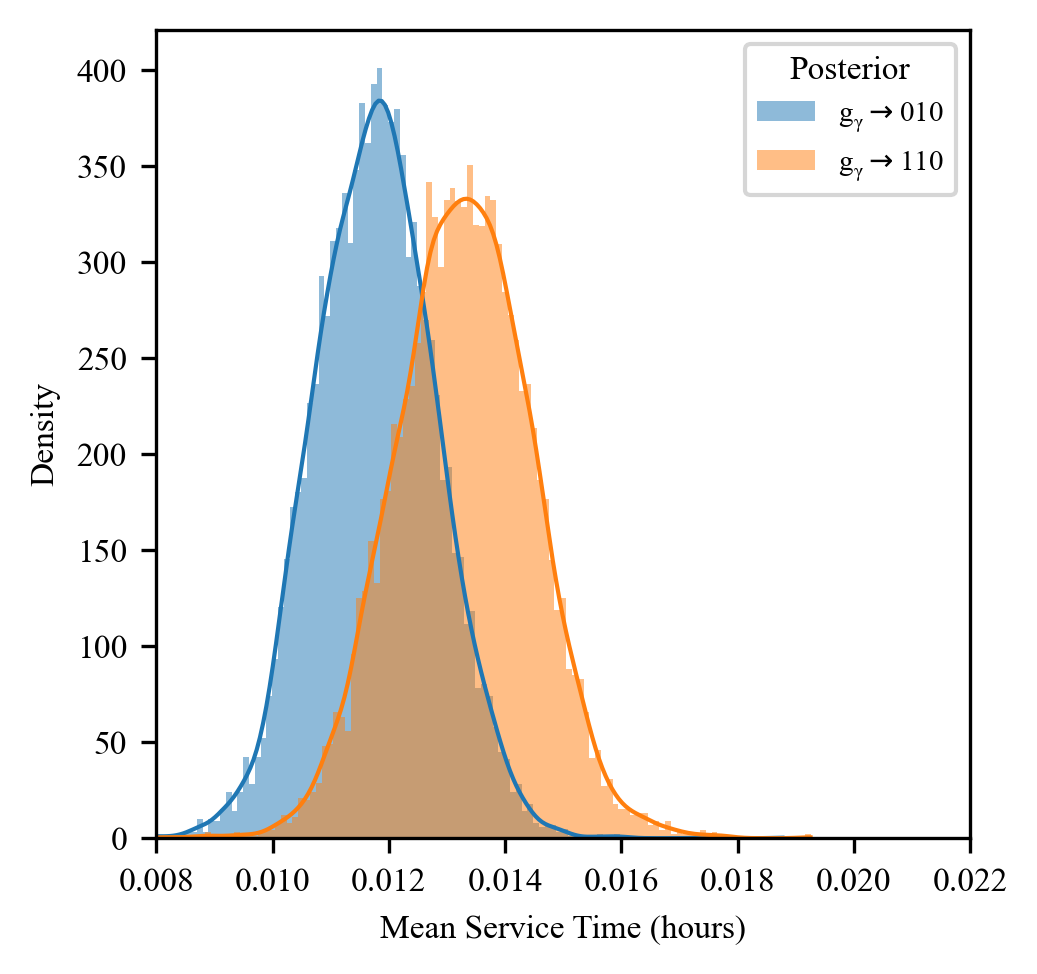

011 posterior, mean=0.01389, std=0.00109
111 posterior, mean=0.01617, std=0.00115


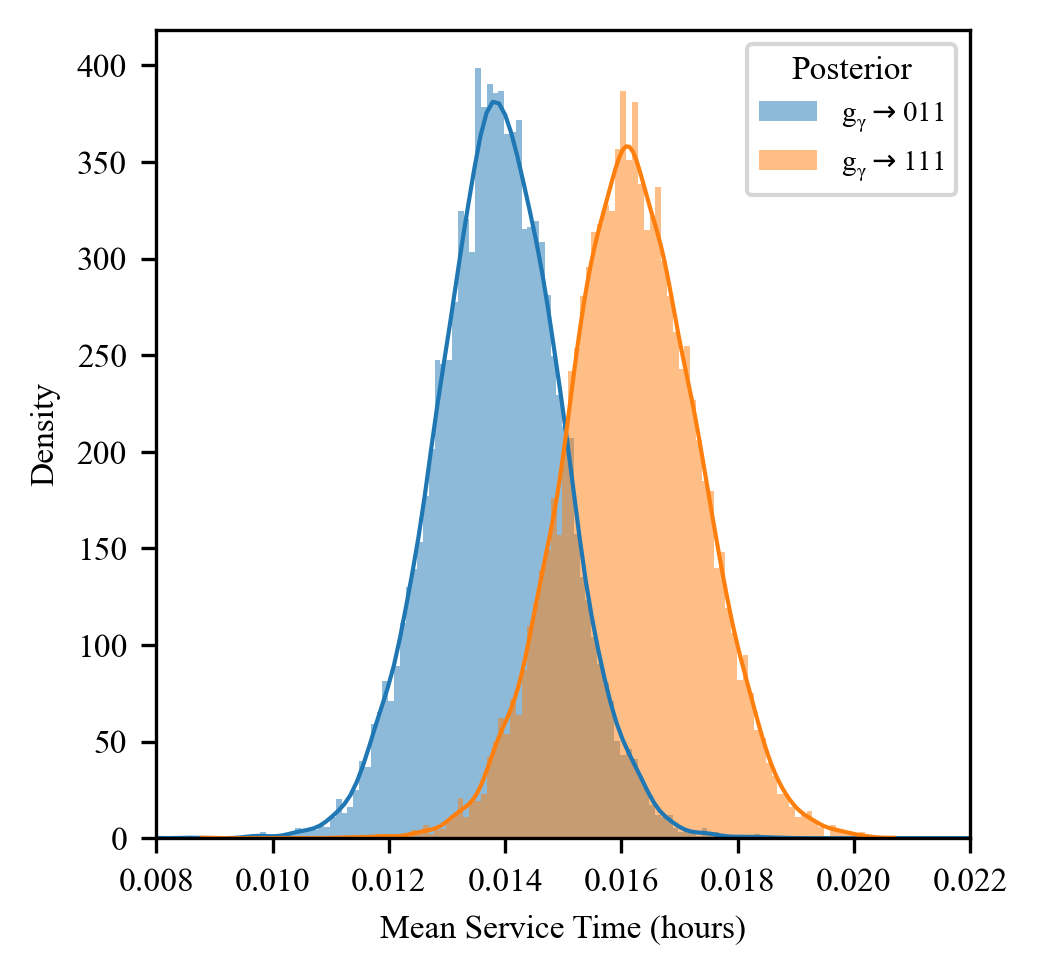

000 posterior, mean=0.01234, std=0.00110
010 posterior, mean=0.01178, std=0.00104


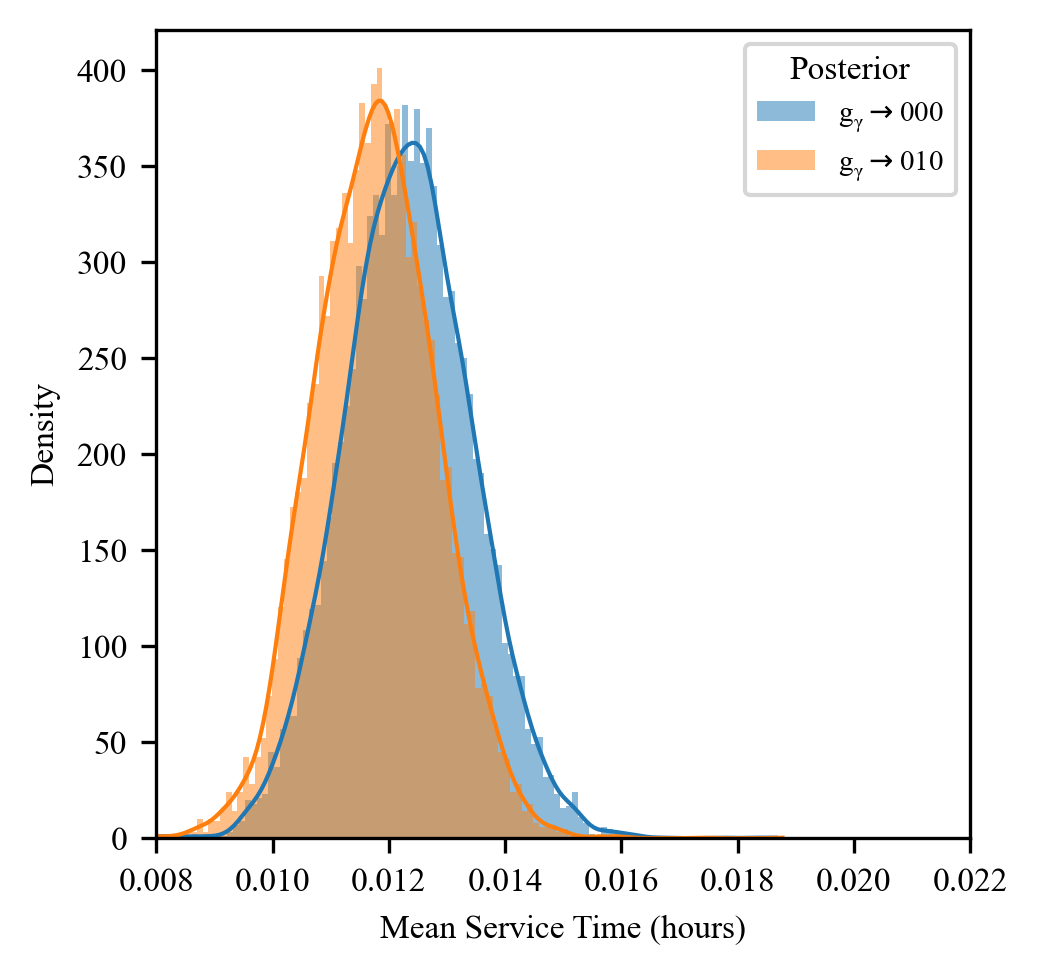

001 posterior, mean=0.01429, std=0.00111
011 posterior, mean=0.01389, std=0.00109


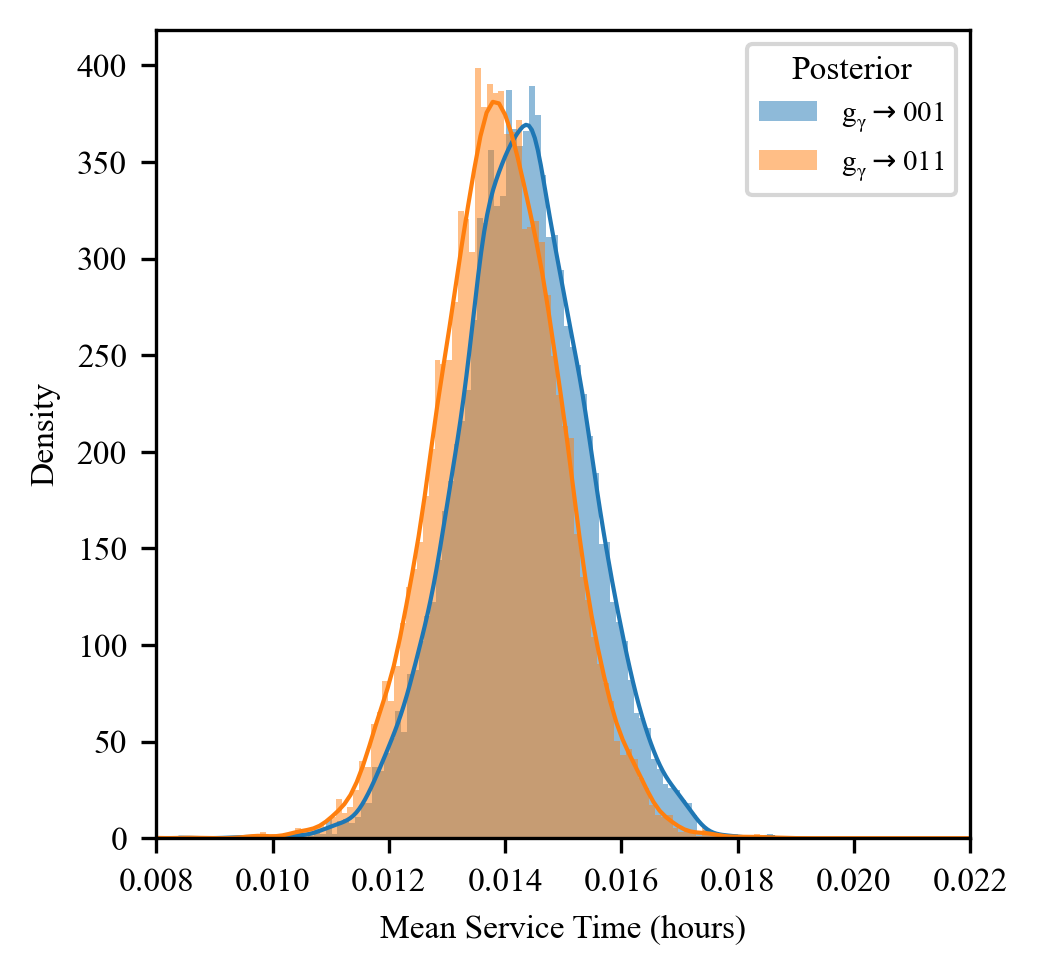

100 posterior, mean=0.01411, std=0.00116
110 posterior, mean=0.01329, std=0.00117


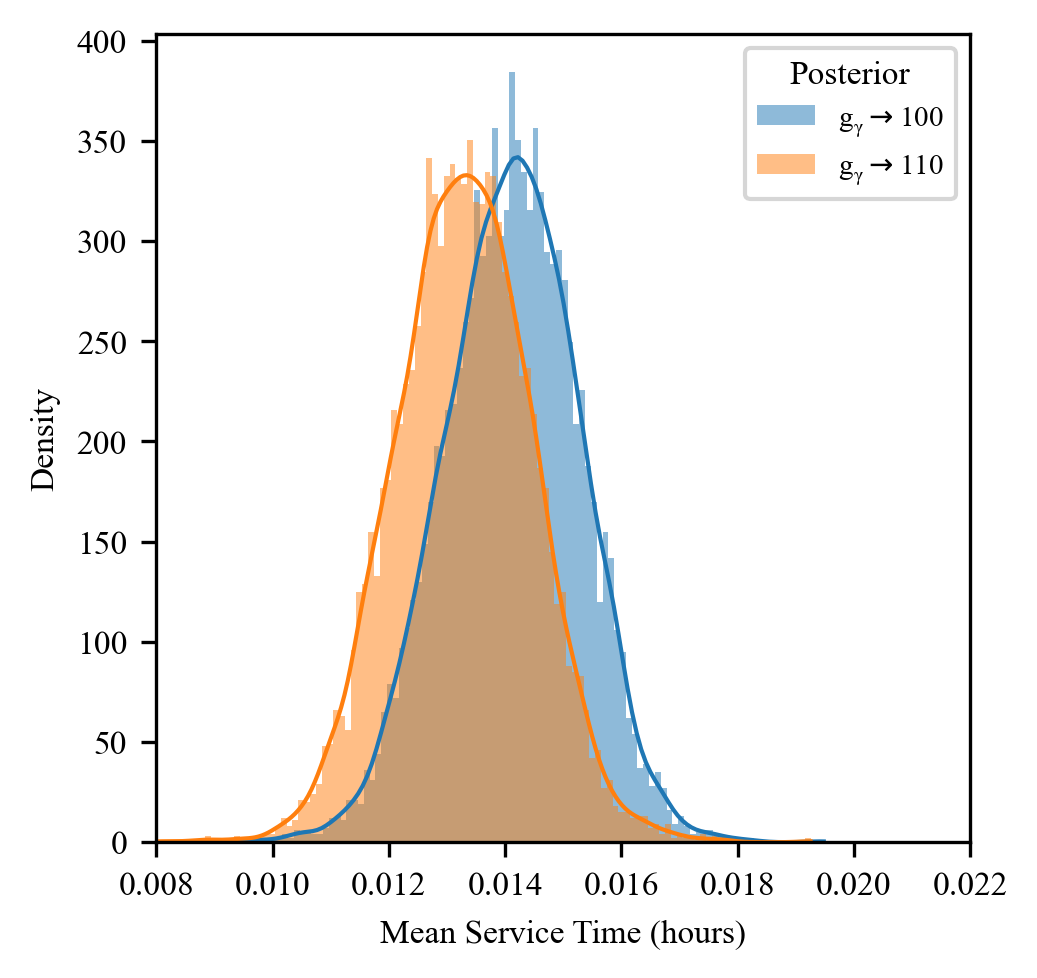

101 posterior, mean=0.01643, std=0.00116
111 posterior, mean=0.01617, std=0.00115


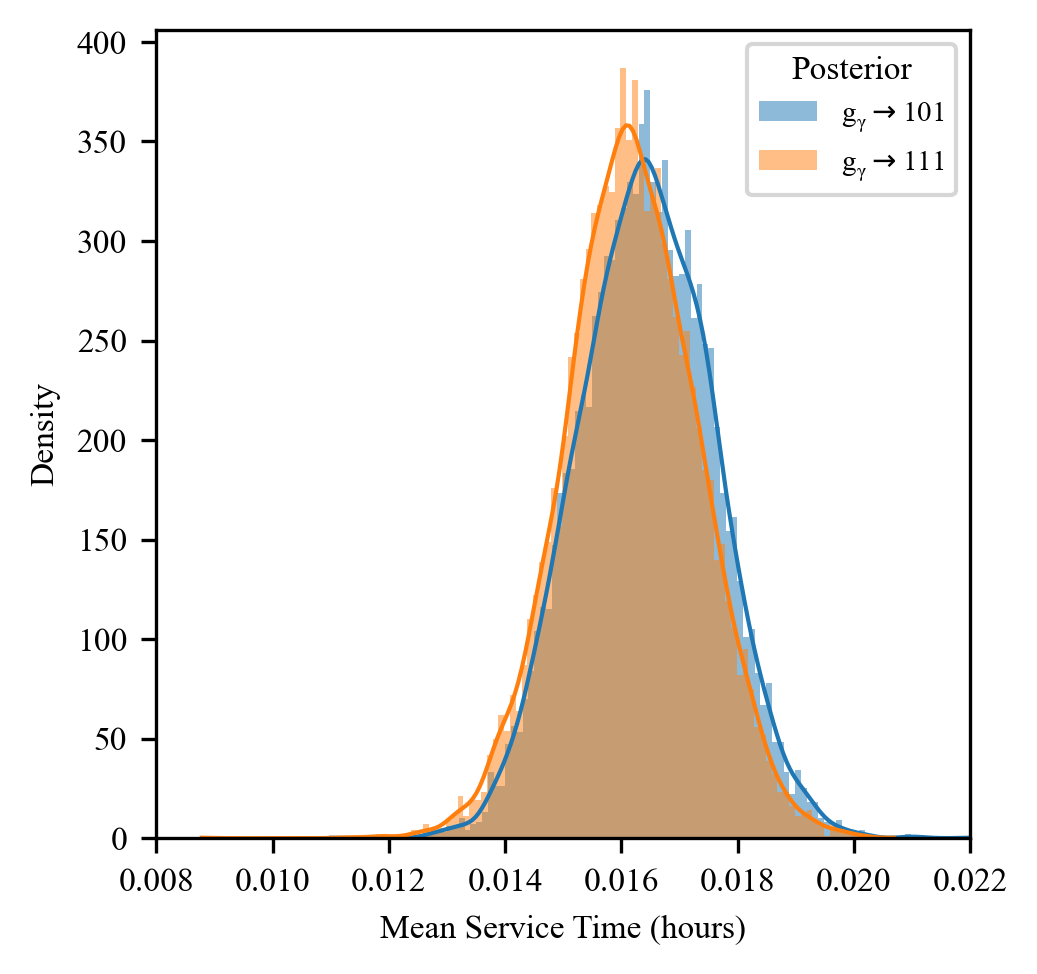

000 posterior, mean=0.01234, std=0.00110
001 posterior, mean=0.01429, std=0.00111


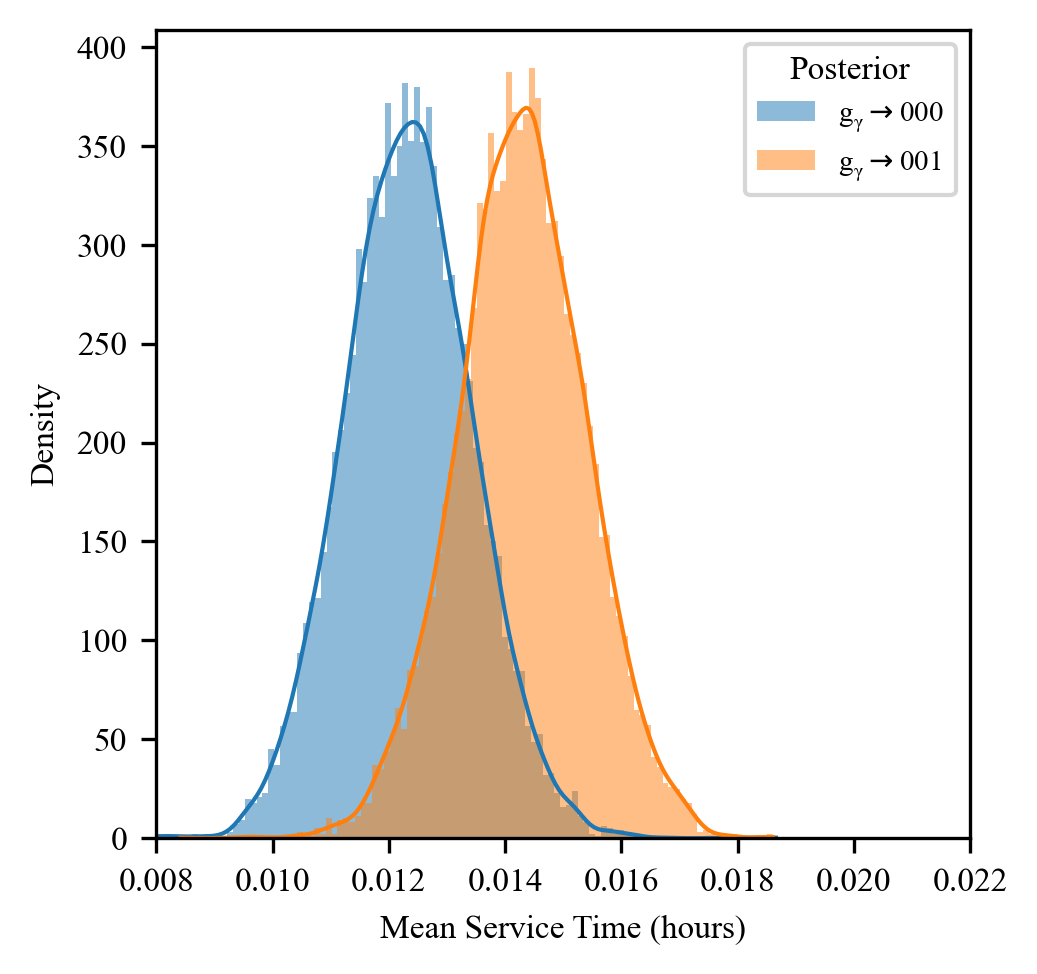

010 posterior, mean=0.01178, std=0.00104
011 posterior, mean=0.01389, std=0.00109


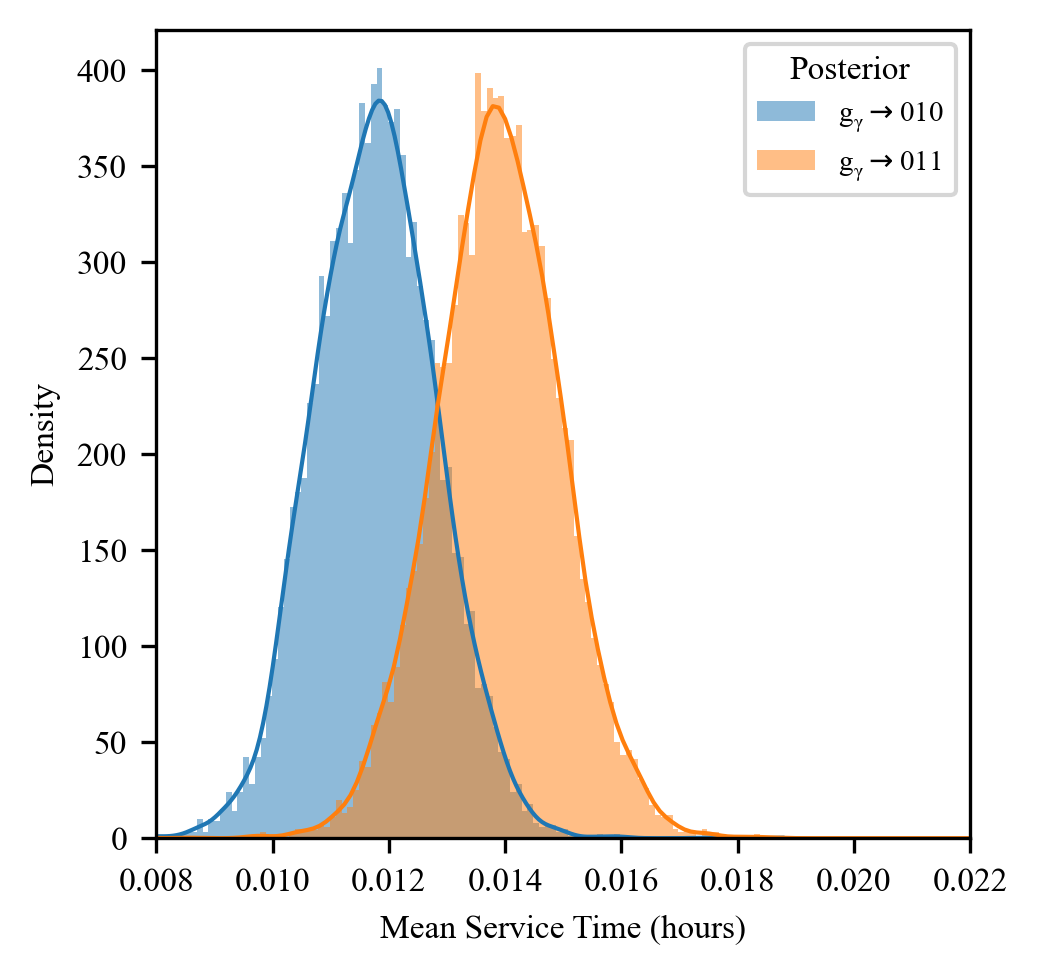

100 posterior, mean=0.01411, std=0.00116
101 posterior, mean=0.01643, std=0.00116


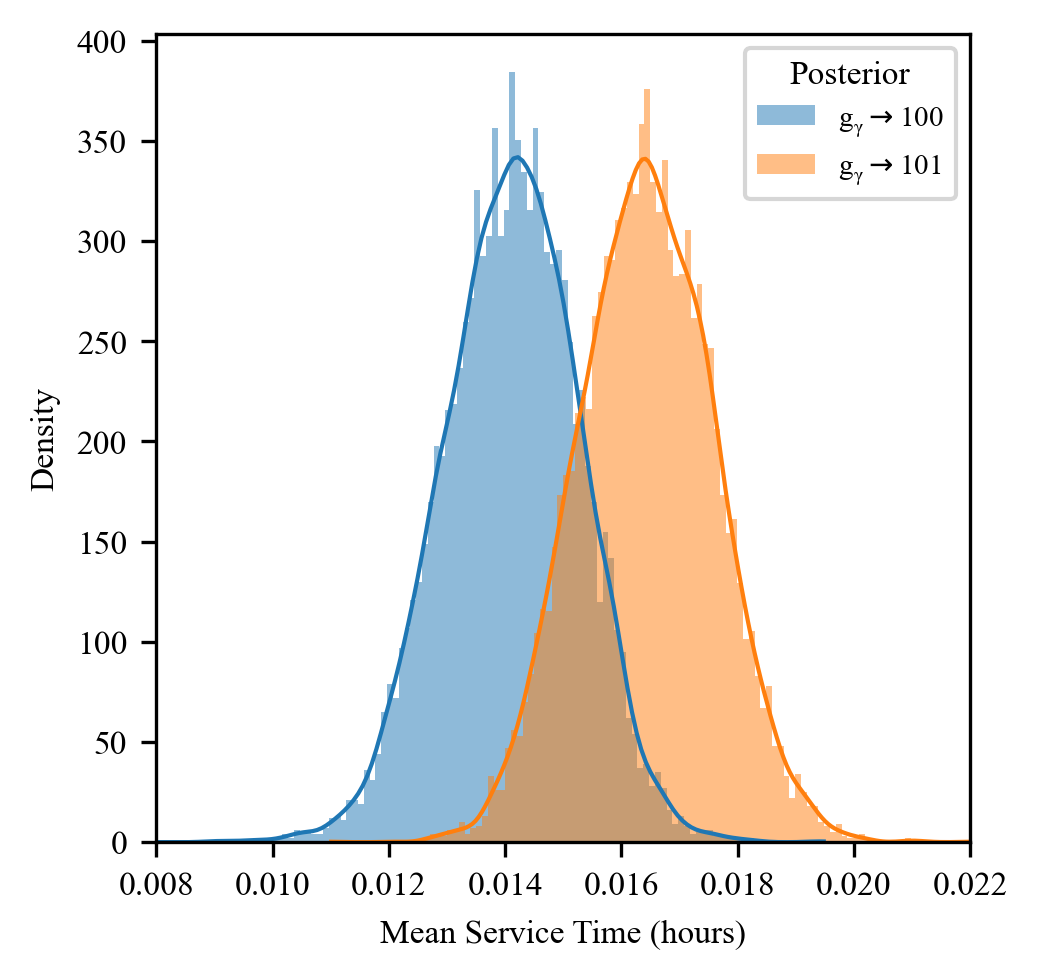

110 posterior, mean=0.01329, std=0.00117
111 posterior, mean=0.01617, std=0.00115


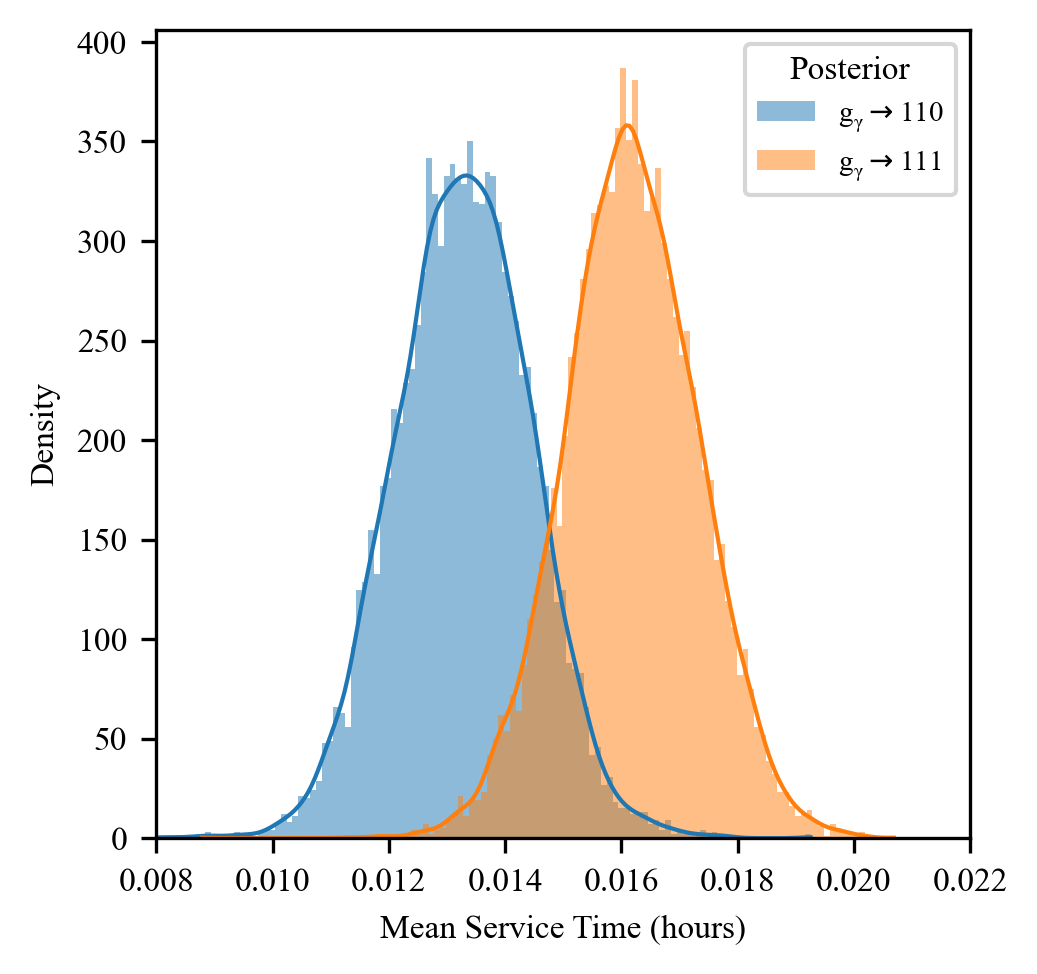

In [22]:
for on in ('y', 'x', 'w'):
    for idx in range(4):
        l = ','.join([a for a in ('y','x','w') if a!=on])
        d = 'left' if on=='x' else 'right'
        fig = plot_from_labels_names_lnp_entry(
            q_samples,
            on, idx, 
            f'varying {on}, holding {l} fixed (order is y,x,w) -- {on}=1 should be to the {d} of {on}=0'
        )
        plt.show(fig)

In [1]:
# ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_80/final/output_dict.pkl'

# with open(ckpt_path, 'rb') as f:
#     output_dict = dill.load(f)

# guide_80 = output_dict['guide']

# for on in ('y', 'x', 'w'):
#     for idx in range(4):
#         l = ','.join([a for a in ('y','x','w') if a!=on])
#         d = 'left' if on=='x' else 'right'
#         fig = plot_from_labels_names_lnp_entry(
#             guide_80,
#             on, idx, 
#             f'varying {on}, holding {l} fixed (order is y,x,w) -- {on}=1 should be to the {d} of {on}=0'
#         )
#         plt.show(fig)

In [23]:
lnp = generate_label_name_pairs(on='y')
print(lnp)

{'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([0., 0., 1., 0., 0.])], [tensor([1., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 1.])], [tensor([0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0.])], [tensor([0., 1., 0., 0., 1.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '100'], ['001', '101'], ['010', '110'], ['011', '111']]}


[('y', [tensor([1., 0., 0., 0., 0.]), tensor([0., 0., 1., 0., 0.])], ['000', '100']), ('y', [tensor([1., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 1.])], ['001', '101']), ('y', [tensor([0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0.])], ['010', '110']), ('y', [tensor([0., 1., 0., 0., 1.]), tensor([0., 0., 0., 1., 1.])], ['011', '111']), ('x', [tensor([1., 0., 0., 0., 0.]), tensor([0., 1., 0., 0., 0.])], ['000', '010']), ('x', [tensor([1., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 1.])], ['001', '011']), ('x', [tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0.])], ['100', '110']), ('x', [tensor([0., 0., 1., 0., 1.]), tensor([0., 0., 0., 1., 1.])], ['101', '111']), ('w', [tensor([1., 0., 0., 0., 0.]), tensor([1., 0., 0., 0., 1.])], ['000', '001']), ('w', [tensor([0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 1.])], ['010', '011']), ('w', [tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 1.])], ['100', '101']), ('w', [tensor([0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 1.]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


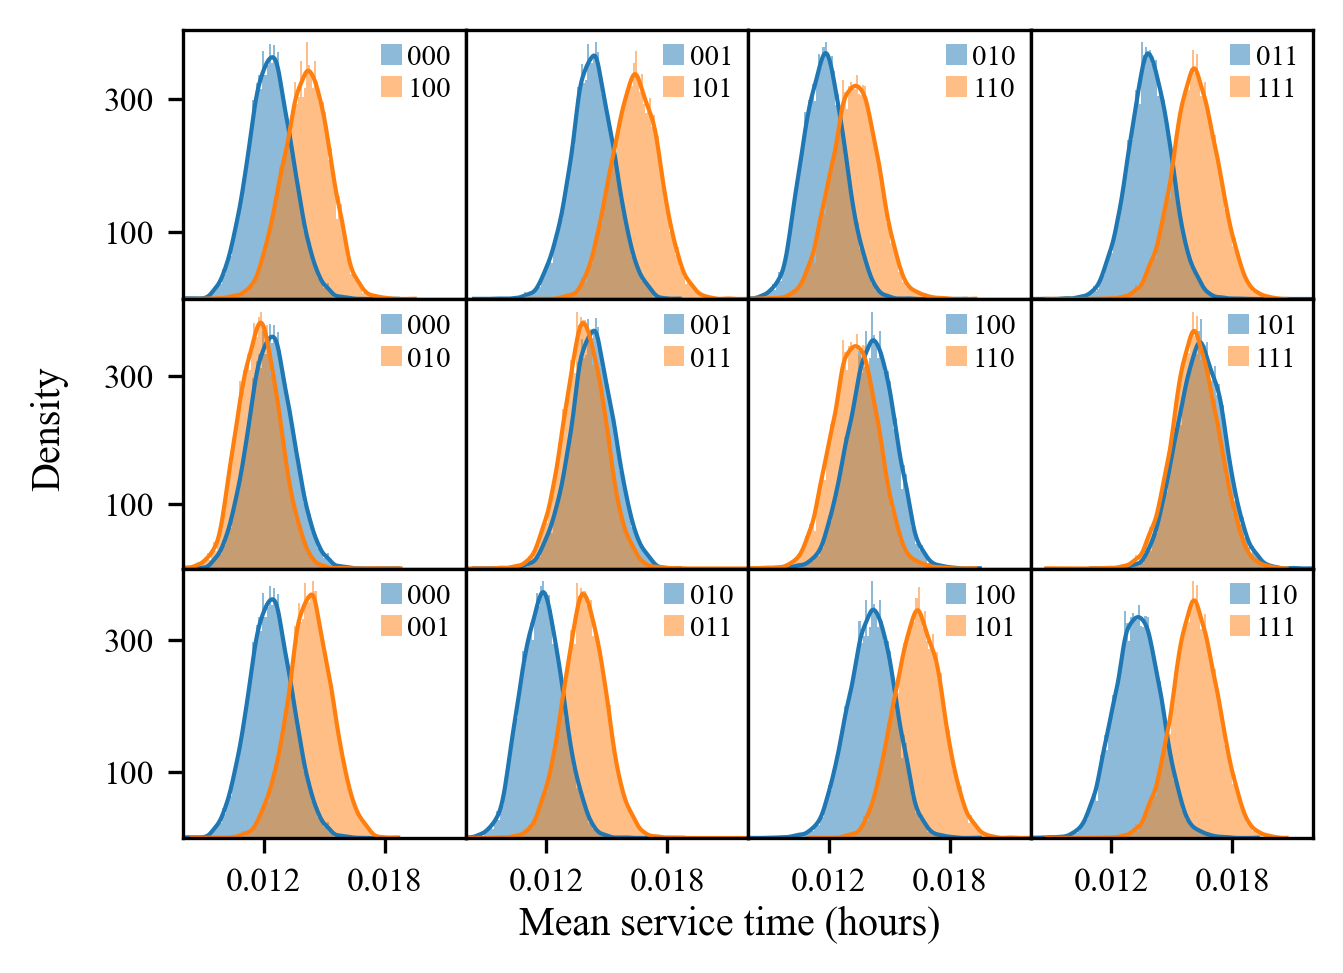

In [99]:
def plot_from_labels_names_grid(samples, title=None, figsize=(4.86,3.5)):

    subplot_spec = []
    for i in range(3):
        subplot_spec.append(
            [f"{i*4 +j}" for j in range(4)]
        )

    fig = plt.figure(figsize=figsize, dpi=300) # layout="constrained", 
    # fig = plt.figure(layout="constrained", figsize=figsize, dpi=300)
    axs = fig.subplot_mosaic(
        subplot_spec, empty_sentinel="X",
                # sharex=True, sharey=True,
        gridspec_kw={
            "wspace": 0,
            "hspace": 0,
        },
    )

    lnp_list = []
    for on in ('y', 'x', 'w'):
        lnp = generate_label_name_pairs(on=on)
        for i in range(4):
            lnp_list.append((on, lnp['label_pairs'][i], lnp['name_pairs'][i]))

    print(lnp_list)

    for i in range(12):
        ax=axs[f"{i}"]

        if i >= 8:
            ax.set_xticks([.012, .018])
        else:
            ax.set_xticks([])
        if i % 4 == 0:
            ax.set_yticks([100,300])
        else:
            ax.set_yticks([])

        con, cl, cn = lnp_list[i]

        plotting_df = {}
        groups = cn

        for group in groups:
            plotting_df[group] = pd.DataFrame(
                {
                    "Mean Service Time (hours)": samples[group],
                    "group": group,
                },
            ) 

        for group in groups:
            
            sns.histplot(
                x="Mean Service Time (hours)",
                data=plotting_df[group],
                ax=ax,
                binwidth=.0001,
                stat="density",
                # shrink=0.8,
                # hue="group",
                # palette=palette,
                edgecolor='none',
                # label=r"$\mathdefault{g_\gamma}\to$" + f"{''.join(list(group))}",
                label=f"{''.join(list(group))}",
                kde=True,
                line_kws=dict(linewidth=1)
            )
            # print(f"{group} posterior, mean={samples[group].mean():.5f}, std={samples[group].std():.5f}"),

        ax.set_xlim(.008, .022)
        ax.legend(
            fontsize=7,
            borderpad=.2,
            borderaxespad=.3,
            handletextpad=.2,
            handlelength=.7,
            labelspacing=.2,
            frameon=False,
            loc='upper right', 
        )

        ax.set_xlabel('')
        ax.set_ylabel('')

        # if i % 4 == 0:
        #     ax.set_ylabel('text')

    fig.supxlabel('Mean service time (hours)')
    fig.supylabel('Density')

    return fig

fig = plot_from_labels_names_grid(q_samples)
for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/q_phi_nsf_730_grid.{ext}', bbox_inches='tight', pad_inches=0)

plt.show()
